# Week 13

More Neural Networks for images... and CNNs...

In [1]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/WK13/raw/main/WK13_utils.py

!wget -qO- https://github.com/DM-GY-9103-2024F-H/9103-utils/releases/latest/download/lfw.tar.gz | tar xz

In [2]:
import torch

from torch import nn
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.transforms import v2

from data_utils import classification_error, display_confusion_matrix
from image_utils import make_image

from WK13_utils import LFWUtils

## Review

Let's quickly review the model from last week.

### Load Data

The version of `LFWUtils.train_test_split()` in this week's utils class will return the data already in sensible `DataLoader` objects, so we don't have to repeat that code.

In [3]:
train, test = LFWUtils.train_test_split(0.5)

### Look at Data

Our `DataLoaders` are iterable objects, which means we need to do a bit of unpacking to get to actual labels and pixels.

jolie


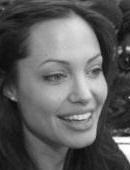

In [4]:
img, label = next(iter(train))
print(LFWUtils.LABELS[label[0]])
display(make_image(img[0], width=130))

### Model, Optimizer, Cost/Loss Function

This is the model from last week.

In [5]:
mdevice = "cuda" if torch.cuda.is_available() else "cpu"
image_length = LFWUtils.IMAGE_SIZE[0] * LFWUtils.IMAGE_SIZE[1]

model =  nn.Sequential(
  nn.Dropout(0.35),
  nn.Linear(image_length, image_length // 2),
  nn.BatchNorm1d(image_length // 2),
  nn.ReLU(),
  # nn.LayerNorm(image_length // 2),

  nn.Dropout(0.35),
  nn.Linear(image_length // 2, image_length // 16),
  nn.BatchNorm1d(image_length // 16),
  nn.ReLU(),
  # nn.LayerNorm(image_length // 16),

  nn.Dropout(0.35),
  nn.Linear(image_length // 16, image_length // 32),
  nn.BatchNorm1d(image_length // 32),
  nn.ReLU(),
  # nn.LayerNorm(image_length // 32),

  nn.Dropout(0.35),
  nn.Linear(image_length // 32, len(LFWUtils.LABELS)),
).to(mdevice)

learning_rate = 5e-3
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

img, label = next(iter(train))
out = model(img)

print("Input shape:", img.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([256, 22100])
Output shape: torch.Size([256, 25])


In [7]:
# TODO: function to count model parameters
# TODO: count model parameters
sum = 0
for p in model.parameters():
  sum += p.numel()
print(sum)

260474578


### Train

In [6]:
for e in range(32):
  model.train()
  for imgs, labels in train:
    optim.zero_grad()
    labels_pred = model(imgs)
    loss = loss_fn(labels_pred, labels)
    loss.backward()
    optim.step()

  if e % 4 == 3:
    print(f"Epoch: {e} loss: {loss.item():.4f}")

Epoch: 3 loss: 2.9481
Epoch: 7 loss: 2.4467
Epoch: 11 loss: 2.1357
Epoch: 15 loss: 1.7246
Epoch: 19 loss: 1.4440
Epoch: 23 loss: 1.2244
Epoch: 27 loss: 1.1662
Epoch: 31 loss: 0.9498


### Eval

Could've been in the loop, but we already know this model...

train error: 0.0831, test error: 0.4886


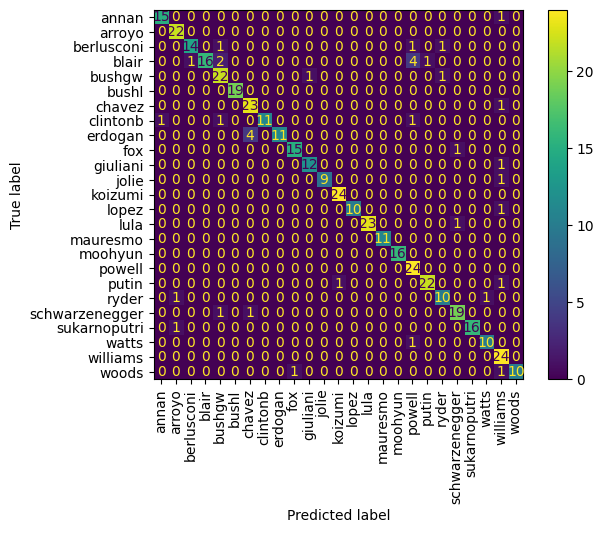

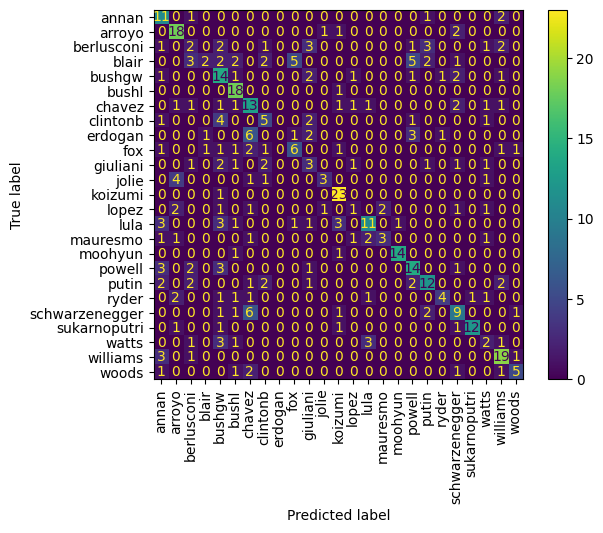

In [8]:
train_labels, train_predictions = LFWUtils.get_labels(model, train)
test_labels, test_predictions = LFWUtils.get_labels(model, test)
train_error = classification_error(train_labels, train_predictions)
test_error = classification_error(test_labels, test_predictions)
print(f"train error: {train_error:.4f}, test error: {test_error:.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)

### Interpretation

Our model did ok, given the limited data that it has to learn from.

Adding Dropout and Batch Normalization helped, but nothing we could do about having few images for some classes...

Until now.

## Make Training Harder Again

One technique for improving the training of a model is to add variability to the training data. This can be done with any kind of data, but is a little bit easier to see with images.

### Image augmentation

This is the process of adding similar, but different data to our training dataset. The new images are created by performing shape and color transformations on the original images, to get variations of the original shapes that we are trying to detect/classify.

Intuitively, what we're trying to do is give the neural network more views of the same objects, and train it to be robust to shape distortions and color variations.

A sideways, distorted and green Arnold Schwarzenegger is still an Arnold Schwarzenegger.

<!-- <img src="./imgs/augmentation.jpg" width="800px" /> -->
<img src="https://i.postimg.cc/kMWgnRLK/augmentation.jpg" width="800px"/>

The `PyTorch` library provides a couple of handy transformation functions for us to add to our training dataset. A more complete list and examples cna be found [HERE](https://pytorch.org/vision/0.13/auto_examples/plot_transforms.html).

### Many Transforms with Composition

Let's create a series of transforms and check what they do to the images.

Some of these have a probability argument `p`, which can be used to specify how often the transformation should be performed.

In [9]:
transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.RandomPerspective(distortion_scale=0.15, p=0.5),
    # v2.RandomResizedCrop(size=(170, 130), scale=(.75, .9), antialias=True),
    # v2.RandomAffine(degrees=15, translate=(0.1, 0.3), scale=(1.1, 1.5))
])

Let's test on the first image of the first batch of our train dataset.

bushgw
Original


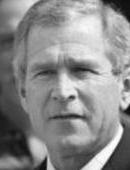

Transformed


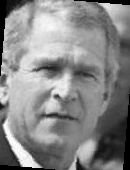

In [10]:
img, label = next(iter(train))
print(LFWUtils.LABELS[label[0]])
img0 = make_image(img[0], width=130)

print("Original")
display(img0)

print("Transformed")
timg0 = transforms(img0)
display(timg0)

### Augment the DataLoader

Since we have to perform this for images in the training dataset, and the `DataLoader` is responsible for giving us batches of randomly ordered images, it makes sense to delegate the transformations to the function that creates the `DataLoader`s.

When it's time for our `DataSet` to grab an image, if there's a transformation function defined, and we're training (computing grads), we'll apply the transformation. Something like:

```py
if self.transform and torch.is_grad_enabled():
  img = self.transform(img)
```

Now we can get our loader one more time, but this time, with image augmentation transformations.

In [11]:
train, test = LFWUtils.train_test_split(0.5, train_transform=transforms)

annan


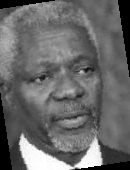

In [12]:
img, label = next(iter(train))
print(LFWUtils.LABELS[label[0]])
img0 = make_image(img[0], width=130)
display(img0)

### Re-Train

Let's re-define our network, optimizer and loss function and see if this helps with training.

In [13]:
mdevice = "cuda" if torch.cuda.is_available() else "cpu"

image_length = LFWUtils.IMAGE_SIZE[0] * LFWUtils.IMAGE_SIZE[1]

model =  nn.Sequential(
  nn.Dropout(0.35),
  nn.Linear(image_length, image_length // 2),
  nn.BatchNorm1d(image_length // 2),
  nn.ReLU(),
  # nn.LayerNorm(image_length // 2),

  nn.Dropout(0.35),
  nn.Linear(image_length // 2, image_length // 16),
  nn.BatchNorm1d(image_length // 16),
  nn.ReLU(),
  # nn.LayerNorm(image_length // 16),

  nn.Dropout(0.35),
  nn.Linear(image_length // 16, image_length // 32),
  nn.BatchNorm1d(image_length // 32),
  nn.ReLU(),
  # nn.LayerNorm(image_length // 32),

  nn.Dropout(0.35),
  nn.Linear(image_length // 32, len(LFWUtils.LABELS)),
).to(mdevice)

learning_rate = 5e-3
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

img, label = next(iter(train))
out = model(img)

print("Input shape:", img.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([256, 22100])
Output shape: torch.Size([256, 25])


In [14]:
for e in range(32):
  model.train()
  for imgs, labels in train:
    optim.zero_grad()
    labels_pred = model(imgs)
    loss = loss_fn(labels_pred, labels)
    loss.backward()
    optim.step()

  if e % 4 == 3:
    print(f"Epoch: {e} loss: {loss.item():.4f}")

Epoch: 3 loss: 3.0969
Epoch: 7 loss: 2.7490
Epoch: 11 loss: 2.4782
Epoch: 15 loss: 2.3775
Epoch: 19 loss: 2.2549
Epoch: 23 loss: 2.0926
Epoch: 27 loss: 2.0088
Epoch: 31 loss: 1.7996


train error: 0.4090, test error: 0.5845


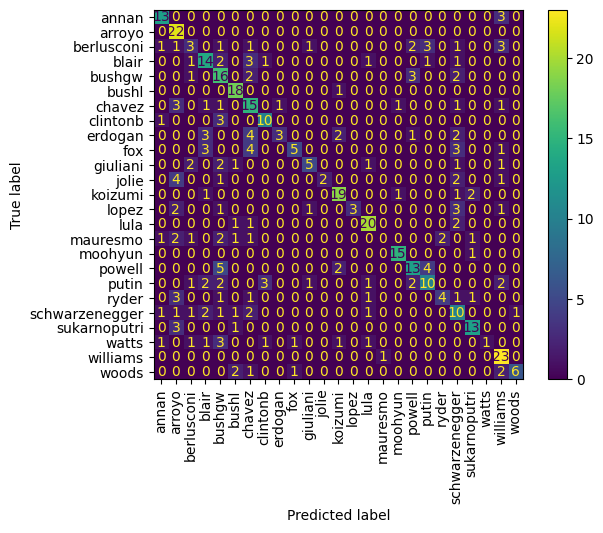

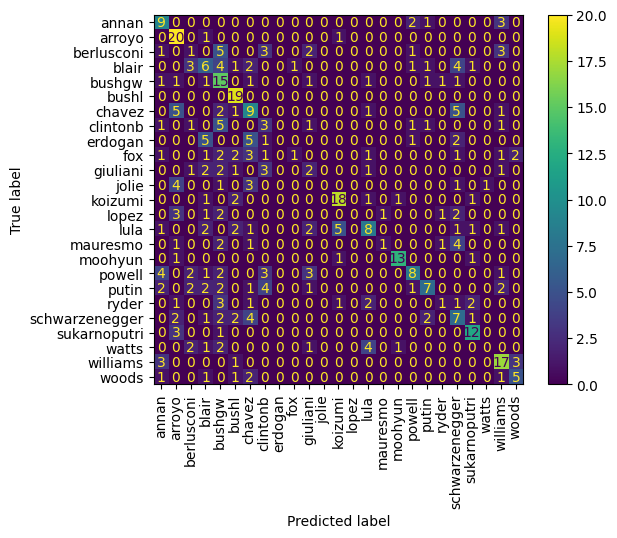

In [15]:
train_labels, train_predictions = LFWUtils.get_labels(model, train)
test_labels, test_predictions = LFWUtils.get_labels(model, test)
train_error = classification_error(train_labels, train_predictions)
test_error = classification_error(test_labels, test_predictions)
print(f"train error: {train_error:.4f}, test error: {test_error:.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)

### Aside: Cost vs. Eval Functions

#### Why we need both

Cost can go down without improving accuracy, precision or recall.

Image we have $2$ samples, with the following correct labels:

`[0, 1]`

Out model computes the following probabilities for each label of each sample:

`[0.1, 0.9], [0.9, 0.1]`

which means it predicts `[1, 0]` for an accuracy of $0\%$, and a cross entropy loss of $1.7$.

After some amount of training, our model improves and now gives the following probabilities for the $2$ samples:

`[0.45, 0.55], [0.51, 0.49]`

making the predicted labels `[1, 0]`, so accuracy is still $0\%$, while the cross entropy loss decreased to $0.7$.

## Spatial Information

Our fully-connected layers do ok for this dataset, but they are not very efficient.

There are $2$ main problems with using this approach to extract information about images:

### Every pixel is connected to every other pixel

Consider the first layer after the input layer: every neuron gets information about every pixel. This means that the content at the top-left corner of our image is connected to the content at the bottom-right corner, which is inefficient. We probably don't need our network to consider the entire content of the image at once in order to make decisions. It jumbles the pixel order and just makes the process harder. We might be better off telling our network to consider groups of neighboring pixels, since it's most likely for visual features to come from pixels that are near each other. In other words, we want to extract and preserve some kind of relative _Locality_ from our pixels.

### Not all Arnolds are the same

Let's say our network learned how to classify an Arnold Schwarzenegger that's closer to the left side of the image. If it wants to detect Arnolds on the right side of the image, or towards the top, it has to learn how to activate neurons that are associated with those sections of the image. This is also inefficient because it has to relearn to detect the same thing again, just because it's somewhere else in the image.

Again, what we would like to do is group neighboring pixels, and have the groups go through similar neurons, so that any kind of learning can be applied independent of where shapes are located in the image. The technical name for this property is _Translation Invariance_.

## Convolutions

We could try to come up with our own architecture and write some code for a neural network that doesn't fully connect our pixels, but rather considers neighboring regions of our image in groups of neurons.

But, luckily, some maths combined with intuition from old-school systems and feature engineering can help us here.

There's a type of mathematical operation called a convolution that combines $2$ arbitrary functions into a new function that basically has information about all the possible combinations of inputs for the $2$ original functions. The math definition looks like this:

$\displaystyle (f * g)(\tau) = \int_{-\infty}^{\infty}{f(\tau)}g(1 - \tau) d\tau$

For the practical, intuitive, definition of this operation when dealing with images, we'll make $f()$ be an image and $g()$ be different, but specific, combinations of numbers organized into $2D$ matrices called kernels.

When we _convolve_ the image with the kernel, we calculate every possible overlap of our kernel with the image and, depending on the numbers we choose for the kernel, can extract different types of features from our pixels.

<!-- <img src="./imgs/kernel_slide.jpg" height="256px"/> -->
<img src="https://i.postimg.cc/wMzHtFnJ/kernel-slide.jpg" height="256px"/>

[SOME ANIMATIONS](https://hannibunny.github.io/mlbook/neuralnetworks/convolutionDemos.html)


Classic image processing kernels for sharpening an image and extracting edges:

<!-- <img src="./imgs/image_kernels.jpg" height="300px"/> -->
<img src="https://i.postimg.cc/fTKWdnzb/image-kernels.jpg" height="300px"/>

The nice thing about these kernels is that they operate on neighboring pixels by default, so they already take into account the _locality_ of the features they're trying to detect.

We can now set up a neural network that is a collection of $2D$ image kernels, and let our training algorithm learn parameters for these kernels based on the training data. We don't have to specify that we want an edge-detection kernel, or a curved-shape kernel, or a horizontal blur kernel... the network will learn the kernels that it needs.

And, since the same kernel slides over an entire image during convolution, once the network learns to extract lines on the left side of the image, it also knows how to extract lines on the right side of the image, or on top, or anywhere else. The parameters to the kernel are the same, they just get applied to different neighborhoods of pixels.

If we combine our bank of kernels with another operation to reduce the size of our image as it moves through the network, we can create a type of dynamic filtering that detects whether certain features are present on our image.

<!-- <img src="./imgs/cnn_layers.jpg" height="320px"/> -->
<img src="https://i.postimg.cc/rpdq7DSd/cnn-layers.jpg" height="320px"/>

Then, after we have reduced our feature maps to a small-enough shape we ca use fully-connected layers to finalize our classification.

<!-- <img src="./imgs/cnn_fc.jpg" height="320px"/> -->
<img src="https://i.postimg.cc/XYYjcHqk/cnn-fc.jpg" height="320px"/>

### New Network, New Loader

Right now our loader returns lists of pixels for each image in a `tensor` of shape $(1, 22100)$. In order to use the convolution layers we actually need the images in a $2D$ tensor of shape $(170, 130)$.

If we were working with color images, CNNs are even more particular, and instead of working with the original image shape of $H \times W \times C$ (`height` by `width` by `channel`), it wants a `tensor` with shape $C \times W \times H$.

It makes sense to add some code to reshape our pixels inside our `FaceDataset` class:
`pxs.reshape(-1, LFWUtils.IMAGE_SIZE[1], LFWUtils.IMAGE_SIZE[0])`

Our `train_test_split()` function just has to know that we want to load our images for a `CNN` now.

In [16]:
transforms = v2.Compose([
	v2.RandomHorizontalFlip(p=0.5),
	v2.RandomRotation(degrees=15),
	v2.RandomPerspective(distortion_scale=0.15, p=0.5),
])

train, test = LFWUtils.train_test_split(0.5, cnn_loader=True, train_transform=transforms)

We can check if we're getting something sensible and if the transformations are working.

batch shape: B x C x H x W


torch.Size([256, 1, 170, 130])

img shape: C x H x W


torch.Size([1, 170, 130])

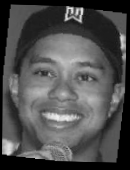

In [17]:
img, label = next(iter(train))

print("batch shape: B x C x H x W")
display(img.shape)

print("img shape: C x H x W")
display(img[0].shape)

display(v2.ToPILImage()(img[0]))

### Define CNN Model

This is how we define a convolution layer:

`nn.Conv2d(Cin, Cout, kernel_size)`

Where `Cin` is the number of input channels, `Cout` is output channels, and `kernel_size` the width of our kernel.

We should still normalize the computations by batch, but this time using the $2D$ version of `BatchNorm()`, and after activation we perform the `MaxPool` operation, which takes the largest value in a $2 \times 2$ region of our activations and condenses them into denser representation of features.

In [18]:
mdevice = "cuda" if torch.cuda.is_available() else "cpu"

width, height = LFWUtils.IMAGE_SIZE

pool_width = (width - 2) // 2
pool_height = (height - 2) // 2

linear_length = pool_width * pool_height * 32

model = nn.Sequential(
  nn.Conv2d(1, 32, 3),
  nn.BatchNorm2d(32),
  nn.ReLU(),
  nn.MaxPool2d(2),

  # More Convs ?

  nn.Flatten(),

  nn.Dropout(0.35),
  nn.Linear(linear_length, 512),
  nn.ReLU(),

  nn.Dropout(0.35),
  nn.Linear(512, len(LFWUtils.LABELS)),
).to(mdevice)

learning_rate = 5e-3
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

img, label = next(iter(train))
out = model(img)

print("Input shape:", img.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([256, 1, 170, 130])
Output shape: torch.Size([256, 25])


### Train CNN

In [19]:
for e in range(32):
  model.train()
  for imgs, labels in train:
    optim.zero_grad()
    labels_pred = model(imgs)
    loss = loss_fn(labels_pred, labels)
    loss.backward()
    optim.step()

  if e % 4 == 3:
    print(f"Epoch: {e} loss: {loss.item():.4f}")

Epoch: 3 loss: 2.8182
Epoch: 7 loss: 2.1317
Epoch: 11 loss: 1.8551
Epoch: 15 loss: 1.4555
Epoch: 19 loss: 1.2744
Epoch: 23 loss: 1.1260
Epoch: 27 loss: 0.9004
Epoch: 31 loss: 0.7537


### Evaluate

train error: 0.1258, test error: 0.4361


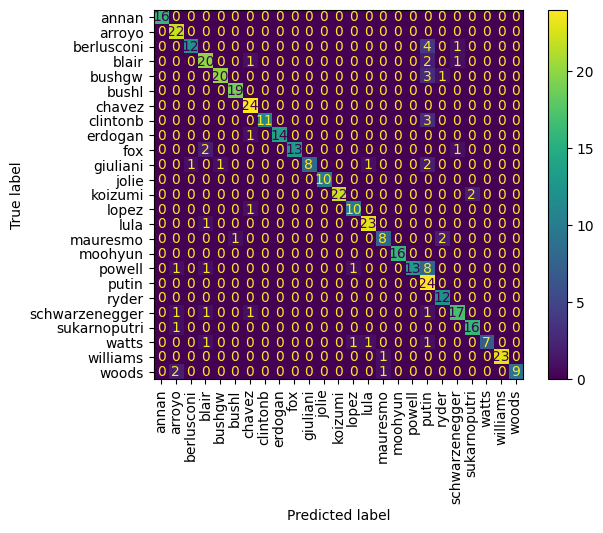

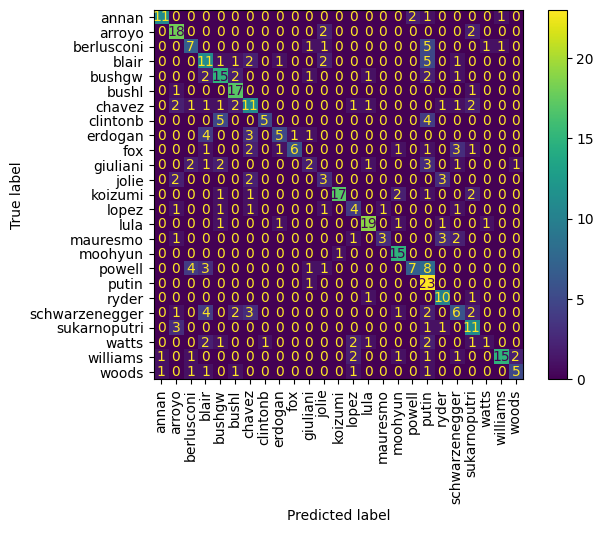

In [20]:
train_labels, train_predictions = LFWUtils.get_labels(model, train)
test_labels, test_predictions = LFWUtils.get_labels(model, test)
train_error = classification_error(train_labels, train_predictions)
test_error = classification_error(test_labels, test_predictions)
print(f"train error: {train_error:.4f}, test error: {test_error:.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)

## Transfer Learning

The CNN architecture is so stable that models can be made to be very deep, some with $100\text{s}$ of layers.

The internal layers of these models are so abstract and generic that once a model has been trained on millions of data samples (images), it learns and retains information not only about the images on the dataset, but any visual pattern that it learned in the process.

It's not uncommon to use a previously trained model for a similar-but-different project, even if the images have nothing in common. Generic information about images can be transferred to new datasets and problem spaces.

<!-- <img src="./imgs/resnet_activation_00.jpg" height="300px" /> -->
<img src="https://i.postimg.cc/tR3twzmz/resnet-activation-00.jpg" height="300px" />

<!-- <img src="./imgs/resnet_activation_01.jpg" height="300px" /> -->
<img src="https://i.postimg.cc/hPKbB7kR/resnet-activation-01.jpg" height="300px" />

<!-- <img src="./imgs/resnet_activation_02.jpg" height="300px" /> -->
<img src="https://i.postimg.cc/15M053Sn/resnet-activation-03.jpg" height="300px" />

### Residual Networks

There are a couple of families of CNN networks that get used as the starting point for many different types of visual models (and also audio and text). One such architecture is [ResNet](https://arxiv.org/abs/1512.03385).

ResNet comes in a few sizes/depths, and PyTorch has at least [5 pre-trained ResNet models](https://pytorch.org/hub/pytorch_vision_resnet/) that we can use.

These PyTorch ResNet models were trained on the [ImageNet](https://image-net.org/download.php) dataset. This dataset has $1\text{,}281\text{,}167$ training images and classifies objects into $1\text{,}000$ classes.

We'll use the `ReNet34` model, which is not the largest, but will fit nicely into small GPUs.

<!-- <img src="./imgs/resnet34_00.jpg" width="900px" /> -->
<img src="https://i.postimg.cc/XNc8xdqy/resnet34-00.jpg" width="900px" />

<!-- <img src="./imgs/resnet34_01.jpg" width="900px" /> -->
<img src="https://i.postimg.cc/hP20Rn9D/resnet34-01.jpg" width="900px" />


### Instantiating ResNet

Is easy:

In [3]:
model = resnet34(weights=ResNet34_Weights.DEFAULT)
# TODO: look at layers
model.fc = nn.Linear(model.fc.in_features, len(LFWUtils.LABELS))

### Adjust inputs

From https://pytorch.org/hub/pytorch_vision_resnet/:

_All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]._

In [4]:
train_transforms = v2.Compose([
	v2.RandomHorizontalFlip(p=0.5),
	v2.RandomRotation(degrees=15),
	v2.RandomPerspective(distortion_scale=0.15, p=0.5),
])

eval_transforms = v2.Compose([
  v2.Resize(224),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train, test = LFWUtils.train_test_split(0.5, resnet_loader=True, train_transform=train_transforms, eval_transform=eval_transforms)

torch.Size([128, 3, 292, 224]) torch.Size([3, 292, 224])


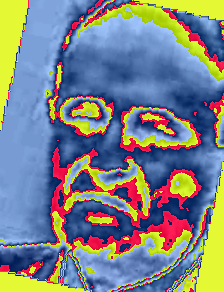

In [5]:
img,label = next(iter(train))
print(img.shape, img[0].shape)
display(v2.ToPILImage()(img[0]))

In [6]:
mdevice = "cuda" if torch.cuda.is_available() else "cpu"

model = resnet34(weights=ResNet34_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(LFWUtils.LABELS))
model = model.to(mdevice)

learning_rate = 5e-3
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

img, label = next(iter(train))
out = model(img)

print("Input shape:", img.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([128, 3, 292, 224])
Output shape: torch.Size([128, 25])


In [ ]:
for e in range(16):
  model.train()
  for imgs, labels in train:
    optim.zero_grad()
    labels_pred = model(imgs)
    loss = loss_fn(labels_pred, labels)
    loss.backward()
    optim.step()

  if e % 4 == 3:
    print(f"Epoch: {e} loss: {loss.item():.4f}")

In [ ]:
train_labels, train_predictions = LFWUtils.get_labels(model, train)
test_labels, test_predictions = LFWUtils.get_labels(model, test)
train_error = classification_error(train_labels, train_predictions)
test_error = classification_error(test_labels, test_predictions)
print(f"train error: {train_error:.4f}, test error: {test_error:.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)